# **Feature Engineering on Time Series Data for Classification**

In [71]:
%matplotlib inline
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.signal import find_peaks
import warnings

from functools import reduce
from operator import add
from numpy.lib.stride_tricks import sliding_window_view

from plotnine import ggplot, geom_bar, aes, theme

warnings.filterwarnings('ignore')

# constants
ACTIVITY_FILEPATH = './data/wisdm/WISDM_ar_v1.1_raw.txt'
ACTIVITIES = ['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing']
COLUMNS = ['user','activity', 'timestamp', 'x-axis', 'y-axis', 'z-axis']

# reading raw data file
activity_df = pd.read_csv(ACTIVITY_FILEPATH, header = None, names = COLUMNS)

# removing null values
activity_df = activity_df.dropna()
activity_df.shape

# transforming the z-axis to float
activity_df['z-axis'] = activity_df['z-axis'].str.replace(';', '')
activity_df['z-axis'] = activity_df['z-axis'].apply(lambda x:float(x))

# drop the rows where timestamp is 0
df = activity_df[activity_df['timestamp'] != 0]

# now arrange data in ascending order of the user and timestamp
df = (df
 .sort_values(by=['user', 'timestamp'], ignore_index=True)
 .rename(columns={'x-axis': 'x', 'y-axis': 'y', 'z-axis': 'z'}))

df.head(3)

,user,activity,timestamp,x,y,z
0,1,Walking,4991922345000,0.69,10.80,-2.03
1,1,Walking,4991972333000,6.85,7.44,-0.50
2,1,Walking,4992022351000,0.93,5.63,-0.50


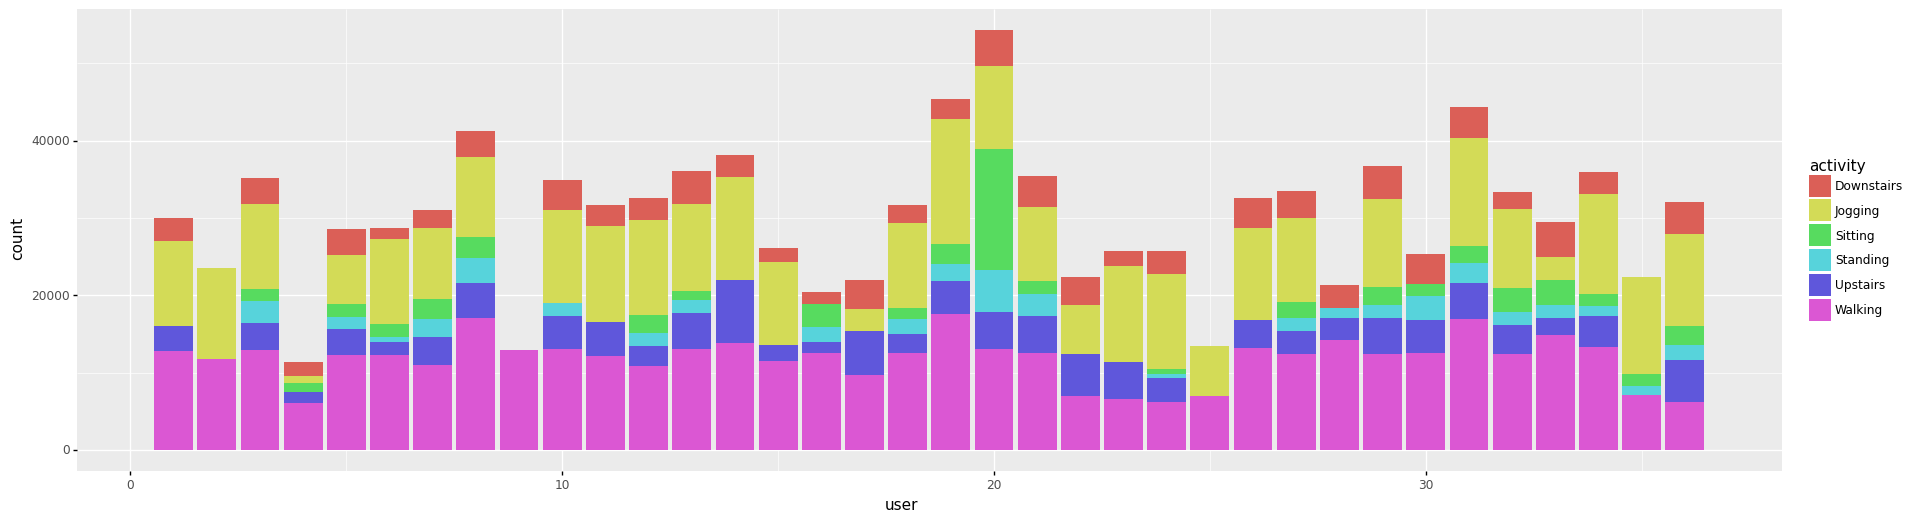

<ggplot: (8783854320017)>

In [30]:
(ggplot(df) +
    aes(x='user', fill='activity') +
    geom_bar(stat='count') +
    theme(figure_size=(22, 6))
)

For a particular user, lets observe how the signal values in each of the x, y and z dimension varies with time.


In [ ]:
for activity in ACTIVITIES:
  data_36 = df[(df['user'] == 36) & (df['activity'] == activity)][:400]
  plt.figure(figsize = (15, 6))
  sns.lineplot(y = 'x', x = 'timestamp', data = data_36)
  sns.lineplot(y = 'y', x = 'timestamp', data = data_36)
  sns.lineplot(y = 'z', x = 'timestamp', data = data_36)

  plt.legend(['x', 'y', 'z'])
  plt.ylabel(activity)
  plt.title(activity, fontsize = 15)
  plt.show()

In all cases, the data is collected every 50 millisecond, that is 20 samples per second.


### **Split data to train and test**

In [112]:
df_train = df[df['user'] <= 27]
df_test = df[df['user'] > 27]

### **Feature Engineering Stage 1: Statistical measures**

In [119]:
aggregations = {
    'mean': lambda x: x.mean(),
    'std': lambda x: x.std(),
    'median': lambda x: np.median(x),
    'aad': lambda x: np.mean(np.absolute(x - np.mean(x))),
    'min': lambda x: np.min(x),
    'max': lambda x: np.max(x),
    'ptp': lambda x: np.ptp(x),
    'mad': lambda x: np.median(np.absolute(x - np.median(x))),
    'iqr': lambda x: np.percentile(x, 75) - np.percentile(x, 25),
    'neg_count':lambda x: np.sum(x < 0),
    'pos_count': lambda x: np.sum(x > 0),
    'above_mean': lambda x: np.sum(x > np.mean(x)),
    'peak_count': lambda x: len(find_peaks(np.array(x))[0]),
    'skewness': lambda x: stats.skew(x),
    'kurtosis': lambda x: stats.kurtosis(x),
    'energy': lambda x: np.sum(x**2) / 100
}

def apply_aggregations(aggregations, df, window=100, step=50, signal_processing=lambda x: x):
    # generate a dictionary of lists of windowed partitions for each of the dimensions x, y and z
    lists_dict = {
        k: list(sliding_window_view(df[k], window)[::step, :])
        for k in ['x', 'y', 'z']
    }

    # turn the above dictionary of lists to a dicitonary of series
    series_dict = {
        k: pd.Series(l).apply(signal_processing) for k, l in lists_dict.items()
    }

    # apply a dictionary comprehension iterating through all series and all aggregations
    single_axis_transformations = {
        f'{axis}_{aggregation_name}': l.apply(aggregation)
        for axis, l in series_dict.items()
        for aggregation_name, aggregation in aggregations.items()
    }

    # using all of the axes for a transformation
    squared_axes = [l**2 for l in series_dict.values()]
    sum_absed = [l.apply(lambda x: np.sum(abs(x)/100)) for l in series_dict.values()]

    # a dictionary of transformations using all of the axes in the same time
    all_axis_aggregations = {
        'avg_result': reduce(add, squared_axes).apply(np.mean),
        'sma': reduce(add, sum_absed)
    }
    # apply each aggregation to each of the axes
    return pd.DataFrame(single_axis_transformations | all_axis_aggregations)


In [120]:
window = 100
step = 50

def extract_window_label_modes(y):
    y_windows = sliding_window_view(y, window)[::step, :]
    modes = [stats.mode(window)[0][0] for window in y_windows]
    return np.array(modes)


X_train = apply_aggregations(aggregations, df_train, window=window, step=step)
y_train = extract_window_label_modes(df_train['activity'])

In [121]:
X_test = apply_aggregations(aggregations, df_test)
y_test = extract_window_label_modes(df_test['activity'])

### **Stage 2: Apply Fast Fourier Transform**

In [98]:
X_train_fft = apply_aggregations(
    aggregations,
    df_train,
    signal_processing=lambda x: np.abs(np.fft.fft(x))[1::]
).add_suffix("_fft")

X_train_all = pd.concat([X_train, X_train_fft], axis=1)

### **Implementing a Linear model for Activity Prediction**

In [122]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
# standardization
scaler = StandardScaler()
scaler.fit(X_train)
X_train_data_lr = scaler.transform(X_train)
X_test_data_lr = scaler.transform(X_test)
# logistic regression model
lr = LogisticRegression(random_state = 21)
lr.fit(X_train_data_lr, y_train)
y_pred = lr.predict(X_test_data_lr)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\n -------------Classification Report-------------\n")
print(classification_report(y_test, y_pred))

Accuracy: 0.798540665598861

 -------------Classification Report-------------

              precision    recall  f1-score   support

  Downstairs       0.59      0.65      0.62       576
     Jogging       0.81      0.95      0.87      1522
     Sitting       0.87      1.00      0.93       361
    Standing       0.95      0.81      0.88       323
    Upstairs       0.67      0.53      0.59       640
     Walking       0.85      0.78      0.81      2197

    accuracy                           0.80      5619
   macro avg       0.79      0.79      0.78      5619
weighted avg       0.80      0.80      0.79      5619



We take a series of signals and aggregate it into windows of data from which to extract new features.
The new features will be used for classification of an aggregated windowed signal.